In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import os
from datetime import datetime
import time
from IPython import display
from tqdm import tqdm

%matplotlib inline

In [18]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.set_default_tensor_type(torch.FloatTensor)
torch.cuda.is_available()

True

In [19]:
class Data(torch.utils.data.Dataset):
    def __init__(self, X, domain, y):
        super(Data, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.domain = torch.tensor(domain, dtype = torch.int64)
        self.y = torch.tensor(y, dtype=torch.int64)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx],self.domain[idx], self.y[idx]

In [20]:
X_train = np.ones((2,1,192,192,192))
domain_train = np.array([2,3,4,5,2,1])
y_train = np.array([1,0,1,1,0,0])

X_val  = np.ones((1,1,192,192,192))
domain_val = np.array([5])
y_val = np.array([1])
train_dataset = Data(X_train,domain_train, y_train)
val_dataset = Data(X_val,domain_val, y_val)

batch_size = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False) 


In [21]:
import sys  
sys.path.insert(0, './models')
from AE_model import AE, Discriminator, Classificator

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [23]:
def mov_ave(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
def plot_loss(train_loss,train_loss_disc, val_loss, val_loss_disc):
    display.clear_output(wait=True)
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    if train_loss:
        ax[0,0].plot(mov_ave(train_loss))
        ax[0,0].set_title('Training loss')
        ax[0,0].set_xlabel('# batches processed')
        ax[0,0].set_ylabel('loss value')
    if train_loss_disc:
        ax[0,1].plot(mov_ave(train_loss_disc))
        ax[0,1].set_title('Training discriminator loss')
        ax[0,1].set_xlabel('# batches processed')
        ax[0,1].set_ylabel('loss value')
    if val_loss:
        ax[1,0].plot(mov_ave(val_loss))
        ax[1,0].set_title('Validation  loss')
        ax[1,0].set_xlabel('# batches processed')
        ax[1,0].set_ylabel('loss value')
    if val_loss_disc:
        ax[1,1].plot(mov_ave(val_loss_disc))
        ax[1,1].set_title('Validation discriminator loss')
        ax[1,1].set_xlabel('# batches processed')
        ax[1,1].set_ylabel('loss value')
    
    plt.show()

In [24]:
def adv_loss(y, pred_logits):
    global n_domains
    global device
    y_onehot = torch.zeros((y.shape[0], n_domains), dtype=torch.int32)
    y_onehot.scatter_(1, y.view(-1,1), 1)
    y_reverse = (1-y_onehot).to(device)
    pred_prob = F.log_softmax(pred_logits,dim=1)
    return -torch.mean(torch.mul(y_reverse, pred_prob))
    del y_onehot, y_reverse, pred_prob

def main_loss(pred_logits_clf, y, pred_logits_domain, domain, criterion_enc_clf, lambda_t):
    
    loss_clf = criterion_enc_clf(pred_logits_clf, y.to(device)) #CrossEntropy loss of classification
    loss_adversarial = adv_loss(domain, pred_logits_domain)
    return loss_clf + lambda_t*loss_adversarial

In [25]:
def train(encoder, disc, clf, criterion_enc_clf, criterion_disc, optimizer_enc_clf, optimizer_disc, 
        train_loader, val_loader,epochs,lambda_initial, lambda_step, max_step, disc_loop=1,scheduler=None, exp_name=None,   save_dir=None):
    global device

    step = 0
    lambda_t = lambda_initial
    
#     writer = SummaryWriter(f'logs/{exp_name}')
    train_loss = [] 
    train_loss_disc = []
    val_loss = []
    val_loss_disc = []
    
    for epoch in range(epochs):
        start_time = time.time()

        for batch_no, (X, domain, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
            '''
            X - ground truth image
            domain - device
            y - epilepsia 
            '''
            X = X.to(device)
            
            ###train discrimintor
            encoder.eval()
            for param in encoder.parameters(): #fix encoder parameters to train disc
                param.requires_grad = False
            disc.train()
            for j in range(disc_loop): ### how in GAN do several iterations for discriminator?
                optimizer_disc.zero_grad()
                pred_logits_domain = disc(encoder(X)[0])
                loss_disc = criterion_disc(pred_logits_domain, domain.to(device))#Cross entropy loss, disc learn to pred real domain
                loss_disc.backward()
                optimizer_disc.step()
            for param in encoder.parameters():
                param.requires_grad = True
            del pred_logits_domain
            ###train encoder
            encoder.train()
            clf.train()
            disc.eval()
            for param in disc.parameters(): # fix discriminator parameters to train encoder
                param.requires_grad = False
            
            optimizer_enc_clf.zero_grad()
            latent, _= encoder(X)
            pred_logits_clf = clf(latent)
            pred_logits_domain = disc(latent)
            loss = main_loss(pred_logits_clf,y.to(device), pred_logits_domain, domain, criterion_enc_clf, lambda_t)
            loss.backward()
            optimizer_enc_clf.step()
            for param in disc.parameters():
                param.requires_grad = True
            del latent, pred_logits_clf, pred_logits_domain
            ### increase lambda
            step += 1
            if step < max_step:
                lambda_t += lambda_step
            
            train_loss.append(loss.item())
            train_loss_disc.append(loss_disc.item())
            ###Plot
            if batch_no % 10 == 0:
                plot_loss(train_loss, train_loss_disc,val_loss, val_loss_disc,)
                print(f'epoch {epoch} training stage...')
#                 writer.add_scalar('train loss', loss.item(), global_step=len(train_loss))
#                 writer.add_scalar('train clas loss', loss_disc.item(), global_step=len(train_loss))

        
        print(f'epoch {epoch} testing stage...')
        encoder.eval()
        clf.eval()
        disc.eval()
        with torch.no_grad():
            for batch_no, (X, domain, y) in tqdm(enumerate(val_loader), 
                                                     total=len(val_loader)):
               
                X = X.to(device)
                latent, _= encoder(X)
                pred_logits_clf = clf(latent)
                pred_logits_domain = disc(latent)
                loss_disc = criterion_disc(pred_logits_domain, domain.to(device))
                loss = main_loss(pred_logits_clf,y, pred_logits_domain,domain, criterion_enc_clf, lambda_t)
                val_loss.append(loss.item())
                val_loss_disc.append(loss_disc.item())
            del latent, pred_logits_domain, pred_logits_clf
#                 writer.add_scalar('val loss', loss.item(), global_step=len(val_loss))
#                 writer.add_scalar('val clas loss', loss_disc.item(), global_step=len(val_loss))

In [26]:
down_block_kwargs = {
    'conv_k': 6,
    'conv_pad': 2,
    'conv_s': 2,
    'maxpool_k': 2,
    'maxpool_s': 2,
    'batch_norm': True,
    'act': 'relu' ##'or l_relu'
}
up_block_kwargs = {
    'up': 'upsample',# or 'transpose_conv'
    'scale': 4,
    'scale_mode': 'nearest',
    'conv_k': 3,
    'conv_pad': 1,
    'conv_s': 1,
    'batch_norm': True,
    'act': 'relu' ##'or l_relu'
}
ae_kwargs ={
    'c_in':1,
    'is_skip': False,
    'deapth': 3,
    'c_base': 32,
    'inc_size':2,
    'reduce_size': False,
    'down_block_kwargs': down_block_kwargs,
    'up_block_kwargs': up_block_kwargs,
}
discriminator_kwargs = {
    'c_in': 128,
    'c_out':512,
    'conv_k': 3,
    'conv_s': 1,
    'conv_pad': 0,
    'l_in': 512,
    'l_out': 256,
    'batch_norm': False,
    'act': 'l_relu',
    'n_domains':18
    
}
classificator_kwargs = {
    'c_in': 128,
    'c_out':512,
    'conv_k': 3,
    'conv_s': 1,
    'conv_pad': 0,
    'l_in': 512,
    'l_out': 256,
    'batch_norm': False,
    'act': 'l_relu',
    'n_class':2
}
n_domains = 18
encoder = AE(**ae_kwargs).enc
disc = Discriminator(**discriminator_kwargs)
clf = Classificator(**classificator_kwargs)
model = AE(**ae_kwargs)

In [28]:
count_parameters(encoder)

320800

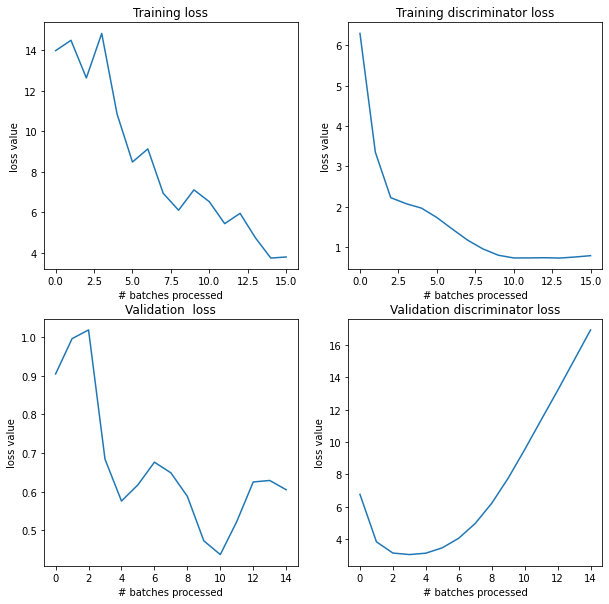

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.55it/s]

epoch 19 training stage...
epoch 19 testing stage...


In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder.to(device)
disc.to(device)
clf.to(device)

lambda_final = 1e-4
lambda_initial = 1e-6
max_step = 50000
lambda_step = (lambda_final-lambda_initial)/max_step

learning_rate_enc = 0.001
betas_enc = (0.9,0.999)
learning_rate_disc = 0.001
betas_disc = (0.9,0.999)

criterion_enc_clf = nn.CrossEntropyLoss()
criterion_disc = nn.CrossEntropyLoss()

optimizer_enc_clf = torch.optim.Adam(list(encoder.parameters()) + list(clf.parameters()), 
                                     lr=learning_rate_enc, betas=betas_enc)
optimizer_disc = torch.optim.Adam(disc.parameters(), lr=learning_rate_disc, betas=betas_disc)

train(encoder, disc,clf, criterion_enc_clf, criterion_disc, optimizer_enc_clf, optimizer_disc,
      train_loader, val_loader,epochs=20,
      lambda_initial=lambda_initial, lambda_step=lambda_step, max_step=max_step, disc_loop=1)
                                     